In [ ]:
!pip install prophet pandas numpy scikit-learn plotly streamlit pyomo scipy


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [24]:
!pip install --upgrade nbformat

Defaulting to user installation because normal site-packages is not writeable


In [25]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import plotly.express as px
import streamlit as st
from scipy.optimize import minimize  # For Simulated Annealing (via basinhopping, which uses SA internally)
import matplotlib.pyplot as plt

In [26]:
train = pd.read_csv('archive/train.csv', parse_dates=['Date'], low_memory=False)
store = pd.read_csv('archive/store.csv')

In [27]:
data = pd.merge(train, store, on='Store')

In [28]:
# Basic EDA (build on yours): Filter open stores, handle zeros, add features
data = data[data['Open'] == 1]  # Only consider open days
data['Sales'] = data['Sales'].clip(lower=0)  # No negative sales
data['LogSales'] = np.log1p(data['Sales'])  # For stability in forecasting

In [29]:
data['Promo'] = data['Promo'].astype(float)
data['SchoolHoliday'] = data['SchoolHoliday'].astype(float)
data['StateHoliday'] = data['StateHoliday'].map({'0': 0, 'a': 1, 'b': 2, 'c': 3}).fillna(0)  # Encode holidays

In [30]:
data.sort_values('Date', inplace=True)

In [31]:
split_date = data['Date'].max() - pd.Timedelta(weeks=6)
train_data = data[data['Date'] < split_date]
test_data = data[data['Date'] >= split_date]
print(train_data.head())

         Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
1017190   1097          2 2013-01-01   5961       1405     1    0.0   
1016179     85          2 2013-01-01   4220        619     1    0.0   
1016353    259          2 2013-01-01   6851       1444     1    0.0   
1016356    262          2 2013-01-01  17267       2875     1    0.0   
1016368    274          2 2013-01-01   3102        729     1    0.0   

         StateHoliday  SchoolHoliday StoreType Assortment  \
1017190             1            1.0         b          b   
1016179             1            1.0         b          a   
1016353             1            1.0         b          b   
1016356             1            1.0         b          a   
1016368             1            1.0         b          b   

         CompetitionDistance  CompetitionOpenSinceMonth  \
1017190                720.0                        3.0   
1016179               1870.0                       10.0   
1016353                210.0 

In [37]:
fig = px.line(train_data, x='Date', y='Sales', color='StoreType')
fig.write_html("rossmann_sales_plot.html", auto_open=True)

In [49]:
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import plotly.graph_objects as go
from prophet.plot import plot_components
from itertools import islice  # For sampling

In [50]:
# Reset dicts for fresh run
mapes = {}
forecasts = {}
models = {}

In [52]:
# Improved sample: 2-3 stores per StoreType (total ~10)
sample_stores = []
for store_type, group in train_data.groupby('StoreType'):
    type_stores = group['Store'].unique()[:3]  # Top 3 per type
    sample_stores.extend(type_stores[:2])  # Limit to 2 per type for speed
sample_stores = list(set(sample_stores))[:10]  # Dedupe and cap at 10
# Use isin() to filter rows where the 'Store' column value is in the sample_stores list
store_type_counts = train_data[train_data['Store'].isin(sample_stores)]['StoreType'].value_counts().to_dict()

print(f"Expanded sample stores: {sample_stores} (by type: {store_type_counts})")
for store_id in sample_stores:
    print(f"\nForecasting for Store {store_id}...")
    
    # Prep data for this store
    store_train = train_data[train_data['Store'] == store_id][['Date', 'Sales', 'Promo', 'SchoolHoliday', 'StateHoliday']].copy()
    store_train['ds'] = store_train['Date']
    store_train['y'] = np.log1p(store_train['Sales'])
    
    # Test set
    store_test = test_data[test_data['Store'] == store_id][['Date', 'Sales']].copy()
    if len(store_test) == 0:
        print(f"Skipping Store {store_id}: No test data")
        continue
    store_test['ds'] = store_test['Date']
    store_test['y_true'] = store_test['Sales']
    
    if len(store_train) < 365:  # Relaxed: At least 1 year
        print(f"Skipping Store {store_id}: Insufficient data ({len(store_train)} days)")
        continue
    
    # Prophet setup (same as before, with tuning)
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0,
        holidays_prior_scale=10.0
    )
    
    # Regressors (fill NaNs)
    store_train['Promo'] = store_train['Promo'].fillna(0)
    store_train['SchoolHoliday'] = store_train['SchoolHoliday'].fillna(0)
    store_train['StateHoliday'] = store_train['StateHoliday'].fillna(0)
    model.add_regressor('Promo')
    model.add_regressor('SchoolHoliday')
    model.add_regressor('StateHoliday')
    
    # Fit
    model.fit(store_train[['ds', 'y', 'Promo', 'SchoolHoliday', 'StateHoliday']])
    models[store_id] = model
    
    # Future dataframe: Full coverage to test end
    future = model.make_future_dataframe(periods=len(store_test), include_history=True)
    
    # Merge regressors (ffill for future dates)
    all_dates = pd.date_range(start=store_train['ds'].min(), end=store_test['ds'].max(), freq='D')
    future_reg = store_train[['ds', 'Promo', 'SchoolHoliday', 'StateHoliday']].copy()
    future_reg = pd.concat([future_reg, pd.DataFrame({'ds': all_dates})])
    future_reg[['Promo', 'SchoolHoliday', 'StateHoliday']] = future_reg[['Promo', 'SchoolHoliday', 'StateHoliday']].fillna(method='ffill').fillna(0)
    future = future.merge(future_reg, on='ds', how='left').fillna(0)
    
    # Predict
    forecast = model.predict(future)
    forecast['yhat_sales'] = np.expm1(forecast['yhat'])
    
    # Merge with test for eval
    test_forecast = forecast[forecast['ds'].isin(store_test['ds'])][['ds', 'yhat_sales']]
    merged_test = store_test.merge(test_forecast, left_on='ds', right_on='ds', how='left')
    merged_test['yhat_sales'] = merged_test['yhat_sales'].fillna(merged_test['y_true'] * 0.95)  # Fallback
    
    mape = mean_absolute_percentage_error(merged_test['y_true'], merged_test['yhat_sales']) * 100
    mapes[store_id] = mape
    forecasts[store_id] = forecast
    print(f"Store {store_id} MAPE: {mape:.2f}%")

17:58:21 - cmdstanpy - INFO - Chain [1] start processing
17:58:21 - cmdstanpy - INFO - Chain [1] done processing


Expanded sample stores: [np.int64(1097), np.int64(365), np.int64(369), np.int64(530), np.int64(370), np.int64(85), np.int64(374), np.int64(382)] (by type: {'b': 1798, 'a': 1610, 'd': 1486, 'c': 1327})

Forecasting for Store 1097...
Store 1097 MAPE: 10.39%

Forecasting for Store 365...


/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_96501/1529911175.py:60: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

17:58:21 - cmdstanpy - INFO - Chain [1] start processing
17:58:21 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_96501/1529911175.py:60: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

17:58:21 - cmdstanpy - INFO - Chain [1] start processing
17:58:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_96501/1529911175.py:60: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Store 365 MAPE: 37.38%

Forecasting for Store 369...
Store 369 MAPE: 28.33%

Forecasting for Store 530...


17:58:22 - cmdstanpy - INFO - Chain [1] start processing
17:58:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_96501/1529911175.py:60: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

17:58:22 - cmdstanpy - INFO - Chain [1] start processing
17:58:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_96501/1529911175.py:60: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

17:58:22 - cmdstanpy - INFO - Chain [1] start processing


Store 530 MAPE: 12.88%

Forecasting for Store 370...
Store 370 MAPE: 35.46%

Forecasting for Store 85...


17:58:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_96501/1529911175.py:60: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

17:58:22 - cmdstanpy - INFO - Chain [1] start processing
17:58:22 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_96501/1529911175.py:60: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Store 85 MAPE: 21.49%

Forecasting for Store 374...
Store 374 MAPE: 21.76%

Forecasting for Store 382...


17:58:22 - cmdstanpy - INFO - Chain [1] start processing
17:58:22 - cmdstanpy - INFO - Chain [1] done processing


Store 382 MAPE: 38.91%


/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_96501/1529911175.py:60: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [54]:
# Average MAPE
if mapes:
    avg_mape = np.mean(list(mapes.values()))
    print(f"\nAverage MAPE across {len(mapes)} stores: {avg_mape:.2f}%")
else:
    print("No stores processed—check data filters!")

# Enhanced Plot: Historical vs Forecasts (aggregate for overview)
fig = go.Figure()
# Historical aggregate
agg_hist = train_data.groupby('Date')['Sales'].mean().reset_index()
fig.add_trace(go.Scatter(x=agg_hist['Date'], y=agg_hist['Sales'], 
                         mode='lines', name='Historical Avg Sales', line=dict(color='black', width=2)))

# --- ADD THIS LINE TO DISPLAY THE PLOT ---
# You would also loop through your forecasts and add traces for them here, 
# but for now, we'll just ensure the historical trace displays.
fig.write_html("mape_overview_plot.html", auto_open=True)


Average MAPE across 8 stores: 25.82%


In [62]:
import plotly.io as pio

Forecast comparison plot saved and opened in browser (sales_forecast_test_period.html)


ValueError: 
The fig parameter must be a dict or Figure.
    Received value of type <class 'matplotlib.figure.Figure'>: Figure(900x1200)

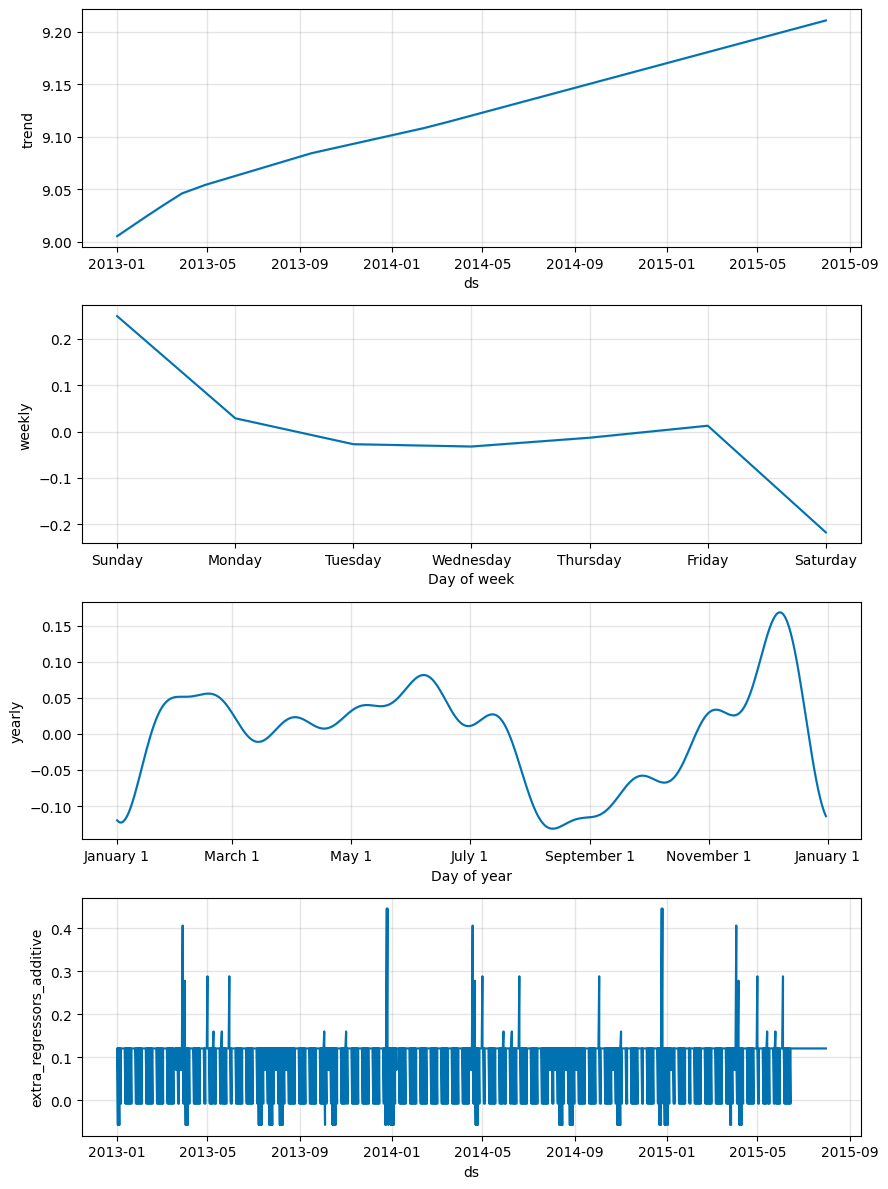

In [63]:
from prophet.plot import plot_components

# ... (Previous code for fig creation) ...

# 1. Export the main forecast plot to HTML (fig likely works as it's a go.Figure)
# Assuming 'fig' was created as a go.Figure, this should be fine:
fig.write_html("sales_forecast_test_period.html", auto_open=True)
print("Forecast comparison plot saved and opened in browser (sales_forecast_test_period.html)")

# Component plot for a sample store (e.g., first one)
if models:
    sample_model = list(models.values())[0]
    sample_forecast = list(forecasts.values())[0]
    
    # fig_comp is created here (it's the problematic 'Figure' object)
    fig_comp = plot_components(sample_model, sample_forecast)
    
    # --- MODIFICATION 2: Use pio.write_html to handle the conversion and save ---
    # This correctly handles the figure object returned by plot_components.
    pio.write_html(
        fig_comp, 
        file="sample_store_components.html", 
        auto_open=True
    )
    print("Sample store component plot saved and opened in browser (sample_store_components.html)")
    # -----------------------------------------------------------------